In [1]:
import os
import mlflow
# Change the current working directory to the D drive
os.chdir("D:/Applied ML/Assignment 2/data")

%cd ..

%cd src/

mlflow.tracking.get_tracking_uri()

D:\Applied ML\Assignment 2
D:\Applied ML\Assignment 2\src


'file:///D:/Applied%20ML/Assignment%202/src/mlruns'

In [2]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import average_precision_score
import mlflow

def load_data(train_path, val_path, test_path, mod_df_path):
    train_df = pd.read_csv(train_path)
    val_df = pd.read_csv(val_path)
    test_df = pd.read_csv(test_path)
    df = pd.read_csv(mod_df_path)
    return train_df, val_df, test_df, df

def preprocess_data(train_df, val_df, test_df):
    vectorizer = CountVectorizer()
    vectorizer.fit(train_df.X_train)
    X_train = vectorizer.transform(train_df.X_train)
    X_val = vectorizer.transform(val_df.X_val)
    X_test = vectorizer.transform(test_df.X_test)
    
    tfidf_trans = TfidfTransformer().fit(X_train)
    tfidf_X_train = tfidf_trans.transform(X_train)
    tfidf_X_val = tfidf_trans.transform(X_val)
    tfidf_X_test = tfidf_trans.transform(X_test)
    
    return tfidf_X_train, tfidf_X_val, tfidf_X_test

def train_model(model, X_train, y_train, hyperparams=None):
    with mlflow.start_run() as run:
        model.fit(X_train, y_train)
        return model

def evaluate_model(model, X_val, y_val):
    val_predictions = model.predict(X_val)
    accuracy = accuracy_score(y_val, val_predictions)
    report = classification_report(y_val, val_predictions)
    confusion = confusion_matrix(y_val, val_predictions)
    return accuracy, report, confusion

def test_model(model, X_test, y_test):
    test_predictions = model.predict(X_test)
    accuracy = accuracy_score(y_test, test_predictions)
    report = classification_report(y_test, test_predictions)
    confusion = confusion_matrix(y_test, test_predictions)
    return accuracy, report, confusion

# Function to calculate AUCPR
def calculate_aucpr(model, X_val, y_val):
    val_predictions_proba = model.predict_proba(X_val)
    aucpr = average_precision_score(y_val, val_predictions_proba[:, 1])
    return aucpr

# Load data
train_path = '../data/train.csv'
val_path = '../data/validation.csv'
test_path = '../data/test.csv'
mod_df_path = '../data/raw_data.csv'
train_df, val_df, test_df, _ = load_data(train_path, val_path, test_path, mod_df_path)

# Preprocess data
tfidf_X_train, tfidf_X_val, tfidf_X_test = preprocess_data(train_df, val_df, test_df)

# Initialize models
nb_model = MultinomialNB(alpha=0.01)  # Setting alpha directly
lr_model = LogisticRegression(C=10.0)  # Setting C directly
svc_model = SVC(probability=True, C=10.0)  # Setting probability and C directly
dt_model = DecisionTreeClassifier(max_depth=None)  # Setting max_depth directly

# Train models
nb_model.fit(tfidf_X_train, train_df.y_train)
lr_model.fit(tfidf_X_train, train_df.y_train)
svc_model.fit(tfidf_X_train, train_df.y_train)
dt_model.fit(tfidf_X_train, train_df.y_train)

# Evaluate models on validation set and calculate AUCPR
nb_accuracy, nb_report, nb_confusion = evaluate_model(nb_model, tfidf_X_val, val_df.y_val)
nb_aucpr = calculate_aucpr(nb_model, tfidf_X_val, val_df.y_val)

lr_accuracy, lr_report, lr_confusion = evaluate_model(lr_model, tfidf_X_val, val_df.y_val)
lr_aucpr = calculate_aucpr(lr_model, tfidf_X_val, val_df.y_val)

svc_accuracy, svc_report, svc_confusion = evaluate_model(svc_model, tfidf_X_val, val_df.y_val)
svc_aucpr = calculate_aucpr(svc_model, tfidf_X_val, val_df.y_val)

dt_accuracy, dt_report, dt_confusion = evaluate_model(dt_model, tfidf_X_val, val_df.y_val)
dt_aucpr = calculate_aucpr(dt_model, tfidf_X_val, val_df.y_val)

# Log models and metrics with MLflow
with mlflow.start_run() as run:
    mlflow.log_param("Model_Type", "Naive Bayes")
    mlflow.log_metric("Validation_Accuracy", nb_accuracy)
    mlflow.log_metric("Validation_AUCPR", nb_aucpr)
    mlflow.sklearn.log_model(nb_model, "Naive_Bayes_Model")
    mlflow.log_artifact("train.ipynb")

with mlflow.start_run() as run:
    mlflow.log_param("Model_Type", "Logistic Regression")
    mlflow.log_metric("Validation_Accuracy", lr_accuracy)
    mlflow.log_metric("Validation_AUCPR", lr_aucpr)
    mlflow.sklearn.log_model(lr_model, "Logistic_Regression_Model")
    mlflow.log_artifact("train.ipynb")

with mlflow.start_run() as run:
    mlflow.log_param("Model_Type", "Support Vector Machine")
    mlflow.log_metric("Validation_Accuracy", svc_accuracy)
    mlflow.log_metric("Validation_AUCPR", svc_aucpr)
    mlflow.sklearn.log_model(svc_model, "Support_Vector_Machine_Model")
    mlflow.log_artifact("train.ipynb")

with mlflow.start_run() as run:
    mlflow.log_param("Model_Type", "Decision Tree")
    mlflow.log_metric("Validation_Accuracy", dt_accuracy)
    mlflow.log_metric("Validation_AUCPR", dt_aucpr)
    mlflow.sklearn.log_model(dt_model, "Decision_Tree_Model")
    mlflow.log_artifact("train.ipynb")

# Test models on test set
nb_test_accuracy, nb_test_report, nb_test_confusion = test_model(nb_model, tfidf_X_test, test_df.y_test)
lr_test_accuracy, lr_test_report, lr_test_confusion = test_model(lr_model, tfidf_X_test, test_df.y_test)
svc_test_accuracy, svc_test_report, svc_test_confusion = test_model(svc_model, tfidf_X_test, test_df.y_test)
dt_test_accuracy, dt_test_report, dt_test_confusion = test_model(dt_model, tfidf_X_test, test_df.y_test)

# Print results
print("Naive Bayes Model:")
print("Validation Accuracy:", nb_accuracy)
print("Validation AUCPR:", nb_aucpr)
print("Test Accuracy:", nb_test_accuracy)
print("Classification Report:")
print(nb_report)
print("Confusion Matrix:")
print(nb_confusion)

print("\nLogistic Regression Model:")
print("Validation Accuracy:", lr_accuracy)
print("Validation AUCPR:", lr_aucpr)
print("Test Accuracy:", lr_test_accuracy)
print("Classification Report:")
print(lr_report)
print("Confusion Matrix:")
print(lr_confusion)

print("\nSupport Vector Machine Model:")
print("Validation Accuracy:", svc_accuracy)
print("Validation AUCPR:", svc_aucpr)
print("Test Accuracy:", svc_test_accuracy)
print("Classification Report:")
print(svc_report)
print("Confusion Matrix:")
print(svc_confusion)

print("\nDecision Tree Model:")
print("Validation Accuracy:", dt_accuracy)
print("Validation AUCPR:", dt_aucpr)
print("Test Accuracy:", dt_test_accuracy)
print("Classification Report:")
print(dt_report)
print("Confusion Matrix:")
print(dt_confusion)
%env GIT_PYTHON_REFRESH=quiet

2024/02/26 16:00:50 WARNING mlflow.utils.git_utils: Failed to import Git (the Git executable is probably not on your PATH), so Git SHA is not available. Error: Failed to initialize: Bad git executable.
The git executable must be specified in one of the following ways:
    - be included in your $PATH
    - be set via $GIT_PYTHON_GIT_EXECUTABLE
    - explicitly set via git.refresh()

All git commands will error until this is rectified.

This initial warning can be silenced or aggravated in the future by setting the
$GIT_PYTHON_REFRESH environment variable. Use one of the following values:
    - quiet|q|silence|s|none|n|0: for no warning or exception
    - warn|w|warning|1: for a printed warning
    - error|e|raise|r|2: for a raised exception

Example:
    export GIT_PYTHON_REFRESH=quiet

C:\Users\VARUN\anaconda3\lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


Naive Bayes Model:
Validation Accuracy: 0.9825581395348837
Validation AUCPR: 0.9996157786885246
Test Accuracy: 0.987783595113438
Classification Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       394
           1       1.00      0.93      0.96       122

    accuracy                           0.98       516
   macro avg       0.99      0.96      0.98       516
weighted avg       0.98      0.98      0.98       516

Confusion Matrix:
[[394   0]
 [  9 113]]

Logistic Regression Model:
Validation Accuracy: 0.9922480620155039
Validation AUCPR: 0.9993367018996493
Test Accuracy: 0.9895287958115183
Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       394
           1       1.00      0.97      0.98       122

    accuracy                           0.99       516
   macro avg       0.99      0.98      0.99       516
weighted avg       0.99      0.99      0.99   

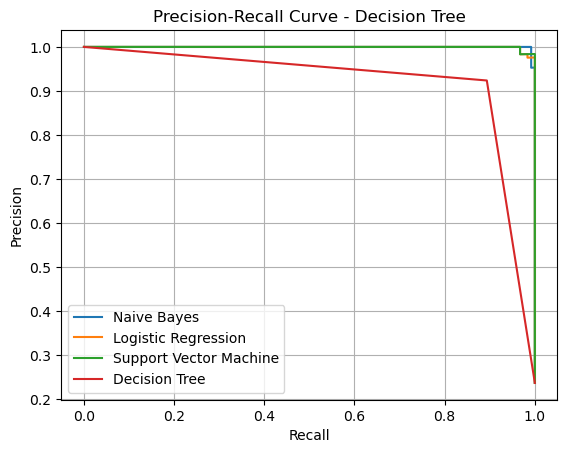

In [4]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve

# Function to plot PR curve
def plot_pr_curve(y_true, y_score, model_name):
    precision, recall, _ = precision_recall_curve(y_true, y_score)
    plt.plot(recall, precision, label=model_name)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve - ' + model_name)
    plt.legend()
    plt.grid(True)

# Plot PR curves for each model
plot_pr_curve(val_df.y_val, nb_model.predict_proba(tfidf_X_val)[:, 1], "Naive Bayes")
plot_pr_curve(val_df.y_val, lr_model.predict_proba(tfidf_X_val)[:, 1], "Logistic Regression")
plot_pr_curve(val_df.y_val, svc_model.predict_proba(tfidf_X_val)[:, 1], "Support Vector Machine")
plot_pr_curve(val_df.y_val, dt_model.predict_proba(tfidf_X_val)[:, 1], "Decision Tree")

plt.show()


Best AUCPR is by naieve bayes model
This code:

Trains multiple models, logs their hyperparameters, and stores the trained models using MLflow.
Evaluates each model on the validation and test sets, printing the results.
Fetches and prints AUCPR for each model from the MLflow runs.